In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io
import sys

sys.path.append("../")
sys.path.append("../..")
from util import *
from model.pinn import *

# 无粘Burgers方程: u_t + u*(u_x1 + u_x2) = 0
# IC:u(x, 0) = 1, x ∈ [0, 1/2]^2; 0, otherwise
# BC:u(0, x2, t) = 1, x2 < (t+1)/2, t∈[0,1]; 0, otherwise
# BC:u(x1, 0, t) = 1, x1 < (t+1)/2, t∈[0,1]; 0, otherwise

# exact solution:
# u(x, t) = 1, x∈[0, (t+1)/2]^2, t∈[0,1]; 0, otherwise

# 构造burgers

无粘Burgers方程: u_t + u*u_x = 0, [-1, 1]*[0, 0.5]

IC:u(x, 0) = 1, x<=0; u(x, 0) = -1, x>0

BC:u(0, t) = u(2π, t)

In [ ]:
def get_data(x_range, y_range, x_num, y_num):
    # 在[x_range]*[y_range]区域采样
    x = np.linspace(x_range[0], x_range[1], x_num)  # [x_range0, x_range1]
    t = np.linspace(y_range[0], y_range[1], y_num)  # [y_range0, y_range1]
    
    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    
    b_init = data[0,:,:]  # 初始时刻
    b_end = data[-1,:,:]
    b_left = data[:,0,:]
    b_right = data[:,-1,:]
    res = data.reshape(-1,2)

    return res, b_init, b_end, b_left, b_right

In [14]:
def get_data(x_range, y_range, x_num, y_num):
    # 在[0,X]^2*[0,T]区域采样
    x1 = np.linspace(x_range[0], x_range[1], x_num)  # [x_range0, x_range1]
    x2 = np.linspace(x_range[0], x_range[1], x_num)  # [x_range0, x_range1]
    t = np.linspace(y_range[0], y_range[1], y_num)  # [y_range0, y_range1]
    print(x1)
    
    x1_mesh, x2_mesh, t_mesh = np.meshgrid(x1, x2, t, indexing='ij')
    data = np.stack((x1_mesh, x2_mesh, t_mesh), axis=-1)  # (x1_num, x2_num, t_num, 3)
    print(data.shape)

    b_init = data[:, :, 0, :]  # 初始时刻
    b_end = data[:, :, -1, :]  # 初始时刻
    b_x1_left = data[0, ...]
    b_x2_left = data[-1, ...]
    res = data.reshape(-1, 3)
    
    return res, b_init, b_end, b_x1_left, b_x2_left

x_range = [0, 1]
y_range = [0, 2]
x_num = 5
y_num = 10

res, b_init, b_end, b_x1, b_x2 = get_data(x_range, y_range, x_num, y_num)
# print(b_init)  # 输出: (250, 3)
# print(b_x1)  # 输出前5个样本点

[0.   0.25 0.5  0.75 1.  ]
(5, 5, 10, 3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 u 是一个 (x_num, x_num, t_num) 形状的三维数组
x_num = 100
t_num = 50
x1 = np.linspace(-1, 7, x_num)
x2 = np.linspace(0, 7, x_num)
t = np.linspace(0, 10, t_num)

# 生成一个示例的三维数组 u
# 这里我们用一个简单的函数生成示例数据
u = np.sin(x1[:, None, None]) * np.cos(x2[None, :, None]) * np.exp(-t[None, None, :])

# 选择一个特定的时间 t 来展示
t_index = 10  # 例如，选择第 10 个时间点
u_slice = u[:, :, t_index]

# 绘制图像
plt.figure(figsize=(5, 5))
plt.imshow(u_slice, extent=[-1, 7, 0, 7], aspect='auto', origin='lower')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title(f'u(x1, x2) at t={t[t_index]:.2f}')
plt.colorbar(label='u(x1, x2, t)')
plt.tight_layout()
plt.show()

In [39]:
def get_data(x_range, y_range, x_num, y_num):
    # 在[0,X]^2*[0,T]区域采样
    x1 = np.linspace(x_range[0], x_range[1], x_num)  # [x_range0, x_range1]
    x2 = np.linspace(x_range[0], x_range[1], x_num)  # [x_range0, x_range1]
    t = np.linspace(y_range[0], y_range[1], y_num)  # [y_range0, y_range1]
    
    x1_mesh, x2_mesh, t_mesh = np.meshgrid(x1, x2, t, indexing='ij')
    data = np.stack((x1_mesh, x2_mesh, t_mesh), axis=-1)  # (x1_num, x2_num, t_num, 3)

    b_init = data[:, :, 0, :]  # 初始时刻
    b_end = data[:, :, -1, :]  # 初始时刻
    b_x1_left = data[0, ...]
    b_x2_left = data[-1, ...]
    res = data.reshape(-1, 3)
    
    return data

def get_burgers(x1, x2, t):
    ind11 = x1 < (t+1)/2
    ind12 = x1 > 0
    ind21 = x2 < (t+1)/2
    ind22 = x2 > 0
    ind31 = t <= 1
    ind32 = t > 0
    ind = ind11 & ind12 & ind21 & ind22 & ind31 & ind32

    if ind :
        return 1
    else:
        return 0


X_SIZE = 201
T_SIZE = 201

data = get_data([0, 1], [1, 0], X_SIZE, T_SIZE)  # (201, 201, 201, 3)
print('points: ', data.shape) 
# 计算解
u = np.zeros((X_SIZE, X_SIZE, T_SIZE))
print('u shape: ', u.shape)
for i in range(X_SIZE):
    for j in range(X_SIZE):
        for k in range(T_SIZE):
            u[i, j, k] = get_burgers(data[i, j, k, 0], data[i, j, k, 1], data[i, j, k, 2])



# x = data[..., 0]
# t = data[..., 1]
# print(x.shape)

# u = get_burgers(x, t)
# print(u.shape)


# # # 定义保存的字典，键名为 'u'
data_dict = {'u': u}

# # # 使用 scipy.io.savemat 保存为 .mat 文件
scipy.io.savemat('2d_burgers.mat', data_dict)

points:  (201, 201, 201, 3)
u shape:  (201, 201, 201)


(201, 201, 201)


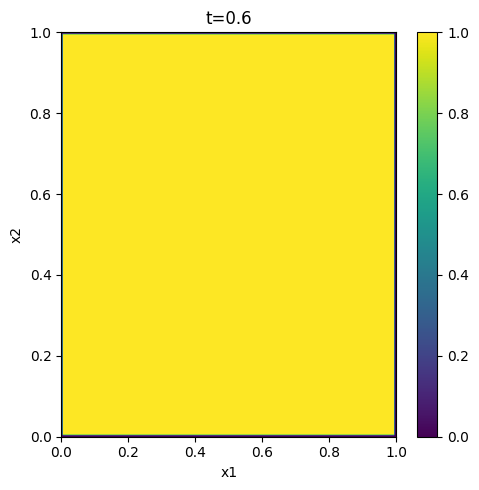

In [38]:
print(u.shape)
u_slice = u[:, :, 0]
plt.figure(figsize=(5,5))
plt.imshow(u_slice, extent=[0,1,0,1], aspect='auto')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('t=0.6')
plt.colorbar()
plt.tight_layout()
plt.show()

(201, 201)


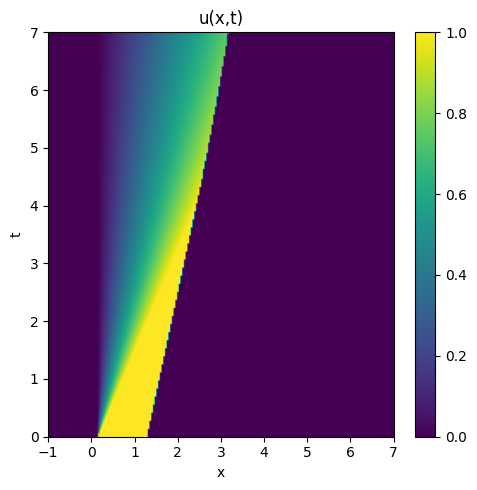

In [7]:
path = '/home/pengguohang/python_test/HCL/pinnsformer/demo/Burgers_competition_2/burgers_c_0.5.mat'

data = scipy.io.loadmat(path)
u = data['u']
print(u.shape)
plt.figure(figsize=(5,5))
plt.imshow(u, extent=[-1,7,0,7], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

# 模型

In [2]:
def get_data(x_range, y_range, x_num, y_num):
    # 在[x_range]*[y_range]区域采样
    x = np.linspace(x_range[0], x_range[1], x_num)  # [x_range0, x_range1]
    t = np.linspace(y_range[0], y_range[1], y_num)  # [y_range0, y_range1]
    
    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    
    b_init = data[0,:,:]  # 初始时刻
    b_end = data[-1,:,:]
    b_left = data[:,0,:]
    b_right = data[:,-1,:]
    res = data.reshape(-1,2)

    return res, b_init, b_end, b_left, b_right

res, _, _, _, _ = get_data([-1, 7], [10, 0], 201, 201) 
res = torch.tensor(res, dtype=torch.float32, requires_grad=True)
x_res, t_res = res[:,0:1], res[:,1:2]
print(x_res.shape, t_res.shape)

torch.Size([40401, 1]) torch.Size([40401, 1])


In [3]:
acti = 'Tanh'
model = Resnet(in_dim=2, hidden_dim=128, out_dim=1, num_layer=4, acti=acti)

u = model(x_res, t_res) 

src:  torch.Size([40401, 2])
x:  torch.Size([40401, 2])
